In [20]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Captum/Captum-Cub200/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Captum/Captum-Cub200


In [ ]:
!pip install captum

In [19]:
ls

attributes.txt  cnn_model.pt   Eff_net_11.pt
Captum-Cub200/  CUB_200_2011/  trial.svg


In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import visualization as viz

In [5]:
torch.manual_seed(0)
np.random.seed(0)

In [6]:
def get_classes(data_dir):
    all_data = torchvision.datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
dataset_path = "CUB_200_2011/images"
classes = get_classes(dataset_path)

In [22]:
model = torch.load("cnn_model.pt")
model = model.eval()

In [23]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [24]:
url = "https://www.audubon.org/sites/default/files/styles/hero_cover_bird_page/public/web_h_andy-morffew_flickr-creative-common-by-2.0_altamiraoriole_flickr-3-adult.jpg?itok=ad9rnLPN"

In [39]:
response = requests.get(url)
im = Image.open(BytesIO(response.content))

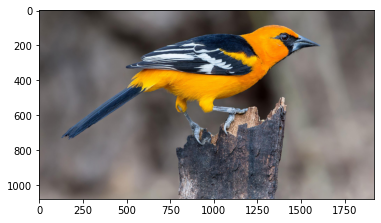

In [40]:
plt.imshow(im)

In [41]:
im = apply_test_transforms(im).unsqueeze(0)

In [42]:
pred = model(im)
_, classnum = torch.max(pred, 1)
print(classnum)

tensor([95])


In [43]:
classes[classnum]

'096.Hooded_Oriole'

In [44]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

In [52]:
attr_methods = {
    'Saliency': Saliency,
    'inputxgradient': InputXGradient,
    'IntegratedGradient': IntegratedGradients,
    'GradientShap' : GradientShap
}

In [53]:
def save_svg(method):

    if method=="GradientShap":
        rand_img_dist = torch.cat([im * 0, im * 1])
        attributions = attr_methods[method](model).attribute(im,
                                                n_samples=50,
                                                stdevs=0.0001,
                                                baselines=rand_img_dist,
                                                target=classnum)
    else:
        attributions = attr_methods[method](model).attribute(im, target=classnum)

    fig,_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                np.transpose(im.squeeze().cpu().detach().numpy(), (1,2,0)),
                                method='heat_map',
                                cmap=default_cmap,
                                show_colorbar=True,
                                sign='positive',
                                outlier_perc=1)
    fig.savefig(fname = f"{method}.svg", format="svg")

/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


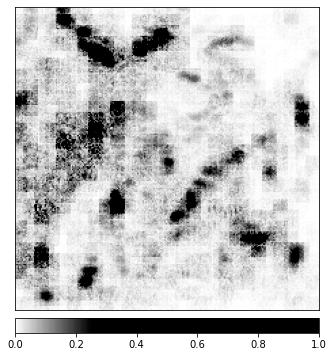

In [54]:
save_svg('Saliency')

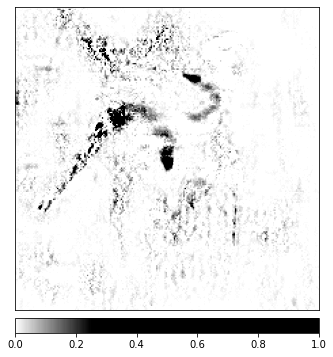

In [55]:
save_svg('inputxgradient')

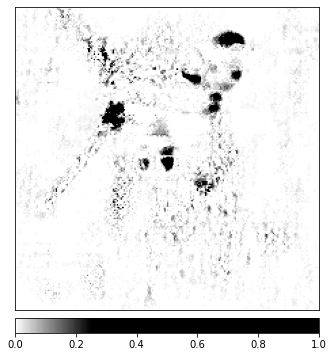

In [56]:
save_svg('IntegratedGradient')

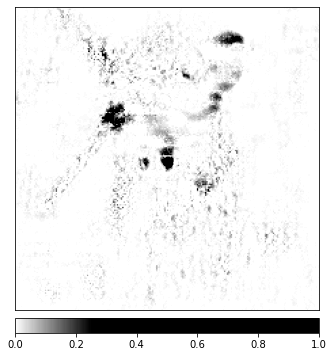

In [57]:
save_svg('GradientShap')